In [1]:
:ext FlexibleContexts
:ext GADTs
:ext OverloadedStrings

In [12]:
import qualified Data.ByteString.Lazy as BS
import qualified Data.ByteString as SBS
import Data.Word
import Data.Either
import Control.Lens ((^.), (^?), ix)
import qualified Data.Vector as V
import qualified Data.Vector.Storable as SV
import qualified Data.Vector.Unboxed as UV
import qualified Data.Aeson as Aeson
import qualified Data.Array.Repa as RP
import Data.Array.Repa ((:.)(..), Z(..))
import qualified Data.Array.Repa.Repr.ForeignPtr as RF
import qualified Codec.Picture as JP
import qualified Codec.Picture.Repa as RPJ
import qualified Codec.Picture.Types as JP
-- import qualified Codec.Picture.Drawing as JP
import qualified Data.Store as Store
import Control.Exception.Base
import IHaskell.Display.Juicypixels hiding (Image)
import Data.Colour.Palette.RandomColor (randomCIELab)
import Data.Colour.SRGB (toSRGB24, RGB(..))
-- import Data.Colour.RGBSpace (uncurryRGB)
import Graphics.Rasterific
import Graphics.Rasterific.Texture
import Graphics.Text.TrueType

import MXNet.Coco.Mask
import MXNet.Coco.Types
import MXNet.Coco.Index
import MXNet.NN.DataIter.Coco

In [13]:
fontCache <- buildCache
Just fontPath = findFontInCache fontCache (FontDescriptor "DejaVu Sans" (FontStyle False False))
Right font <- loadFontFile fontPath

In [14]:
load path = do
    bs <- SBS.readFile path
    Store.decodeIO bs

store path obj = do 
    SBS.writeFile path (Store.encode obj)
    return obj

In [15]:
data Y8

class ToDynamicImage a where
    toDynamicImage :: RPJ.Img a -> JP.DynamicImage

instance ToDynamicImage Y8 where
    toDynamicImage (RPJ.Img arr0) = JP.ImageY8 $ JP.Image w h (SV.unsafeFromForeignPtr0 (RF.toForeignPtr arr) (h*w*z) )
      where 
        (Z :. h :. w :. z) = RP.extent arr
        arr = RP.computeS arr0 

In [17]:
Coco _ _ inst <- coco "/home/jiasen/dschungel/coco" "val2017"
anns = inst ^. annotations
imgs = inst ^. images
cats = inst ^. categories

In [ ]:
heatmap anno = do
    -- (anno ^. ann_image_id, anno ^. ann_bbox)
    let SegPolygon polys = anno ^. ann_segmentation
    crle <- frPoly (map SV.fromList polys) 427 640
    mask <- decode crle
    -- RP.extent mask
    let maskHW = RP.backpermute (Z :. 427 :. 640 :. 1) (\ (Z :. c :. w :. h) -> Z :. h :. w :. c) mask
    -- RP.extent maskHW
        img = toDynamicImage (RPJ.Img $ RP.map (*255) maskHW :: RPJ.Img Y8)
    return (RPJ.convertImage img :: RPJ.Img RPJ.RGBA)

imgHeatmap <- heatmap (V.head anns)

theImg = V.head $ V.filter ( (== anno ^. ann_image_id) . (^. img_id)) imgs
theImgPath = "/home/jiasen/dschungel/coco/train2017/" ++ theImg ^. img_file_name
Right imgRaw <- RPJ.readImageRGBA theImgPath

imgBlend = RP.zipWith (\u0 u1 -> floor $ fromIntegral u0 * 0.4 + fromIntegral u1 * 0.6) (RPJ.imgData imgHeatmap) (RPJ.imgData imgRaw)

mutableBlendImg <- JP.thawImage $ JP.convertRGB8 $ RPJ.imgToImage (RPJ.Img imgBlend)

(x0, y0, w0, h0) = anno ^. ann_bbox
x1 = x0 + w0
y1 = y0 + h0
JP.drawRectangle mutableBlendImg (floor x0) (floor y0) (floor x1) (floor y1) (JP.PixelRGB8 0 0 255)

imgWithBB <- JP.freezeImage mutableBlendImg
imgWithBB

In [ ]:
-- build mapping: image -> [annotation]

In [22]:
imgAnns = V.filter (\ann -> ann ^. ann_image_id == 87038) anns
V.map (^. ann_bbox) imgAnns

[(253.21,271.07,59.59,60.97),(226.04,229.31,11.59,30.41),(257.85,224.48,44.13,97.0),(68.18,238.19,16.18,42.88),(79.16,232.26,28.22,51.12),(98.4,234.28,19.52,46.46),(326.86,223.46,13.11,38.67),(155.27,246.34,14.87,21.99),(298.61,316.85,63.91,47.19),(345.41,173.41,72.94,185.41),(239.72,225.38,10.64,33.06),(167.02,234.0,15.78,37.46),(209.68,231.08,9.15,34.53),(408.29,231.25,17.12,34.97),(204.14,229.02,7.33,34.96),(195.32,228.06,10.65,37.18),(1.0,190.0,638.0,101.0)]

In [19]:
theImg = V.head $ V.filter ( (== 87038) . (^. img_id)) imgs
theImgPath = "/home/jiasen/dschungel/coco/val2017/" ++ theImg ^. img_file_name
Right imgRawDyn <- JP.readImage theImgPath
imgRaw = JP.convertRGBA8 imgRawDyn :: JP.Image JP.PixelRGBA8

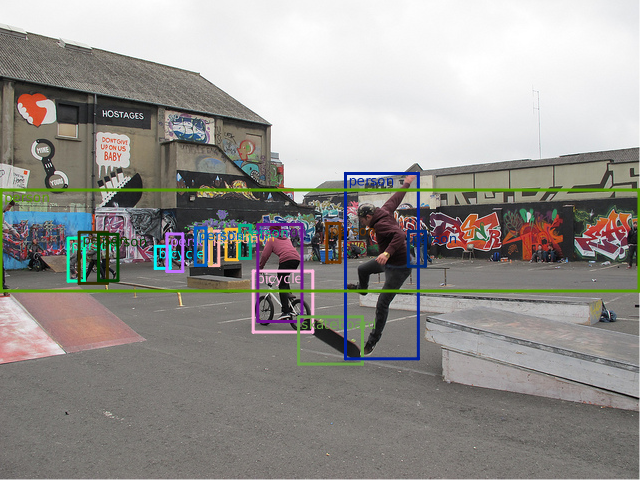

In [20]:
drawBB ann color = 
    withTexture (uniformTexture color) $ do
        stroke 3 JoinRound (CapRound, CapRound) $ rectangle (V2 x0 y0) w0 h0
        printTextAt font (PointSize 10) (V2 (x0+2) (y0+12)) catName
  where
    (x0, y0, w0, h0) = ann ^. ann_bbox
    cat = V.head $ V.filter (\cat -> cat ^. odc_id == (ann ^. ann_category_id)) cats
    catName = cat ^. odc_name

colors <- V.generateM (length imgAnns) (\ _ -> do
            RGB r g b <- toSRGB24 <$> randomCIELab
            return $ JP.PixelRGBA8 r g b 255)

renderDrawing (theImg ^. img_width) (theImg ^. img_height) (JP.PixelRGBA8 255 255 255 255) $ do
    drawImage imgRaw 0 (V2 0 0)
    V.zipWithM_ drawBB imgAnns colors

In [ ]:
import GHC.Stats
getRTSStats

In [ ]:
a = RP.fromListUnboxed (Z :. (2 :: Int) :. (2 :: Int)) [1,2,3,4]
b = RP.fromListUnboxed (Z :. (2 :: Int) :. (2 :: Int)) [4,3,2,1]

In [ ]:
:ext PartialTypeSignatures

In [ ]:
c <- RP.computeP $ a RP.+^ b :: IO (RP.Array RP.U _ _)

In [ ]:
c